In [1]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter 
from scipy.spatial.distance import pdist


In [2]:
from transformers import AutoTokenizer, DistilBertModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, DistilBertConfig, DistilBertTokenizer, DistilBertTokenizerFast, DistilBertPreTrainedModel, DistilBertForTokenClassification, DistilBertForSequenceClassification

from datasets import Dataset
from accelerate import Accelerator

In [3]:
from bs4 import BeautifulSoup
import re
from sklearn import preprocessing

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
        classification_report, confusion_matrix, r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
) 

from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier, XGBRegressor, plot_importance
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [7]:

from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor


import tqdm as notebook_tqdm
from tqdm import tqdm

In [8]:
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings


In [9]:
complaints = pd.read_csv("../data/complaints.csv")

In [10]:
class TextCleaner():
    def __init__(self):
        pass
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text

cleaner = TextCleaner()
complaints['Consumer complaint narrative'] = complaints['Consumer complaint narrative'].apply(cleaner.clean_text)
complaints

,Consumer complaint narrative,Issue
0,my name is xxxx xxxx this complaint is not mad...,Incorrect information on your report
1,i searched on xxxx for xxxxxxxx xxxx and was p...,Fraud or scam
2,i have a particular account that is stating th...,Incorrect information on your report
3,i have not supplied proof under the doctrine o...,Attempts to collect debt not owed
4,hello im writing regarding account on my credi...,Incorrect information on your report
...,...,...
353427,collections account i have no knowledge of,Attempts to collect debt not owed
353428,dear cfpb team the reason for my complaint is ...,Attempts to collect debt not owed
353429,frca violations failing to follow debt dispute...,Attempts to collect debt not owed
353430,my father a xxxx xxxx acquired an hecm reverse...,Struggling to pay mortgage


In [11]:
y_raw = complaints['Issue']

label_encoder = preprocessing.LabelEncoder()
complaints['Issue'] = label_encoder.fit_transform(complaints['Issue'].tolist())

y_encoded = complaints['Issue']
y_encoded

In [12]:
X = complaints[['Consumer complaint narrative']]
X

,Consumer complaint narrative
0,my name is xxxx xxxx this complaint is not mad...
1,i searched on xxxx for xxxxxxxx xxxx and was p...
2,i have a particular account that is stating th...
3,i have not supplied proof under the doctrine o...
4,hello im writing regarding account on my credi...
...,...
353427,collections account i have no knowledge of
353428,dear cfpb team the reason for my complaint is ...
353429,frca violations failing to follow debt dispute...
353430,my father a xxxx xxxx acquired an hecm reverse...


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_raw, test_size = 0.2, random_state = 321, shuffle=True, stratify = y_raw)

In [14]:


X_train_tokens = X_train['Consumer complaint narrative'].fillna("").apply(str.split)

X_test_tokens = X_test['Consumer complaint narrative'].fillna("").apply(str.split)

tfidf = TfidfVectorizer(stop_words='english')

# ngrams from 1 to 3 and minimum document frequency of 20
# tfidf = TfidfVectorizer(ngram_range=(1,3), min_df = 20)

X_train_vec = tfidf.fit_transform(X_train_tokens.apply(lambda x: ' '.join(x)))
X_test_vec = tfidf.transform(X_test_tokens.apply(lambda x: ' '.join(x)))

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)

y_test_enc = le.transform(y_test)

xgb_model = xgb.XGBClassifier( enable_categorical=True, 
                              objective='multi:softmax', 
                              num_class=len(le.classes_), 
                              n_estimators=1000,  #10000, for 92% accuracy (Macro)
                              use_label_encoder=True, 
                              eval_metric='mlogloss',
                              random_state = 535)


xgb_model.fit(X_train_vec, y_train_enc)

y_pred_enc = xgb_model.predict(X_test_vec)

y_pred = le.inverse_transform(y_pred_enc)

/Users/bentonwang/Library/Python/3.13/lib/python/site-packages/xgboost/training.py:183: UserWarning: [14:52:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [15]:
accuracy_score(y_test, y_pred)

0.9002928402676589

In [16]:
confusion_matrix(y_test, y_pred)

array([[11126,   488,    72,  2889,    58],
       [  748,  3293,    14,   177,    17],
       [   86,    23,  2179,   170,    11],
       [ 1874,    52,    37, 43816,    82],
       [   52,    26,    10,   162,  3225]])

In [17]:
print(classification_report(y_test, y_pred, zero_division = 0, target_names=['Attempts to Collect Debt Not Owed', 'Communication Tactics', 'Fraud or Scam', 'Incorrect Information on Your Report', 'Struggling to Pay Mortgage']))  

                                      precision    recall  f1-score   support

   Attempts to Collect Debt Not Owed       0.80      0.76      0.78     14633
               Communication Tactics       0.85      0.78      0.81      4249
                       Fraud or Scam       0.94      0.88      0.91      2469
Incorrect Information on Your Report       0.93      0.96      0.94     45861
          Struggling to Pay Mortgage       0.95      0.93      0.94      3475

                            accuracy                           0.90     70687
                           macro avg       0.89      0.86      0.88     70687
                        weighted avg       0.90      0.90      0.90     70687



# Top Features' Importance Quantification


In [18]:
selection = SelectFromModel(xgb_model, threshold=0.0001, prefit=True)

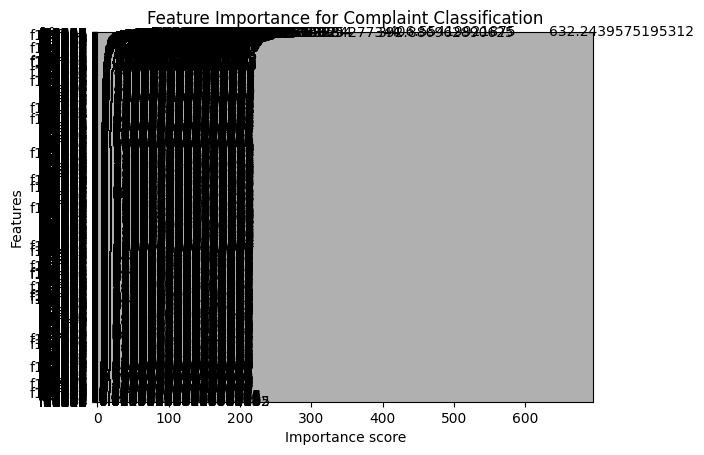

In [19]:
plot_importance_object = plot_importance(xgb_model, importance_type='gain')
plt.title('Feature Importance for Complaint Classification')
plt.show()

In [20]:
X_feature_names = tfidf.get_feature_names_out()
X_feature_names

array(['00', '000', '0000', ..., 'zwicke', 'zwicker', 'zwickers'],
      shape=(102167,), dtype=object)

In [21]:
importances = xgb_model.feature_importances_

In [22]:
importance_df = pd.DataFrame({'word': X_feature_names, 'importance': importances})   

In [23]:
importance_df = importance_df.sort_values(by='importance', ascending=False)

importance_df = importance_df[importance_df['importance'] > 0]

importance_df.head(30)

,word,importance
60059,mute,0.033168
29550,declaration,0.021328
1504,16661666b,0.020611
58842,modification,0.010933
37640,expartner,0.007446
12477,anybody,0.007401
90487,transunion,0.006495
53762,lead,0.006348
37734,experian,0.006202
36288,equifax,0.005516
